# Evaluation Planar Robot

In this notebook we evaluate the extended A* using a planar robot with 3, 6 and 9 DoF. First let us take a look at the environments used for evaluation:

----- benchmark: simple -----


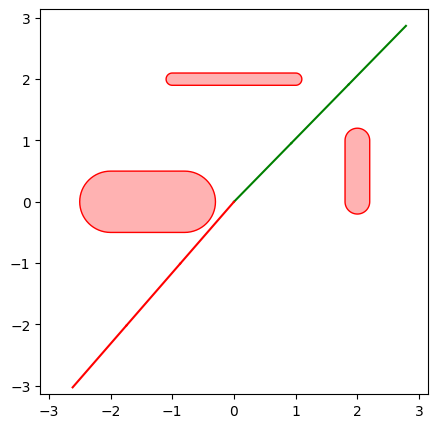

----- benchmark: narrow_passage -----


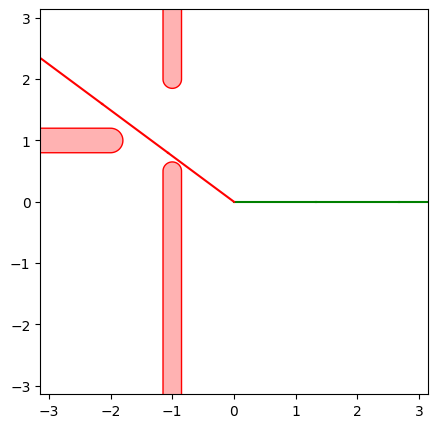

----- benchmark: complex_scene -----


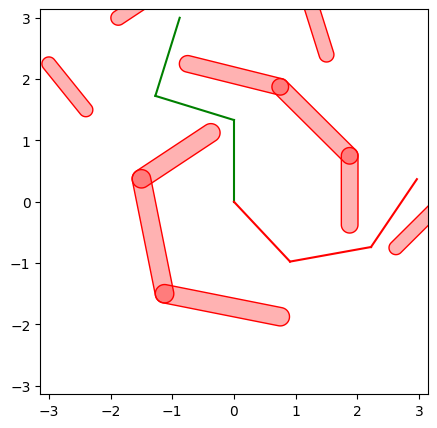

In [46]:
from core.IPBenchmark import Benchmark 
import evaluation.robotic_arm.IPTestSuite_robotic_arm_3_DoF as ts
import matplotlib.pyplot as plt

from evaluation.robotic_arm.PlotEnvironments import visualizeBenchmark

for benchmark in ts.benchList:
        benchmark: Benchmark
        print(f"----- benchmark: {benchmark.name} -----")
        fig, ax = visualizeBenchmark(benchmark)
        plt.show()

## Evaluation Code

In this section you can find some code for evaluating A*, loading existing results and plotting the results.

In [47]:
import os
import json
import networkx as nx
from typing import List, Dict

import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'core'))
sys.path.append(os.path.join(os.getcwd(), 'evaluation/robotic_arm'))

from core.IPAStarExtended import AStar
from evaluation.robotic_arm.Benchmarking import get_config_dir_name, evaluate
import evaluation.robotic_arm.IPTestSuite_robotic_arm_3_DoF as ts3
import evaluation.robotic_arm.IPTestSuite_robotic_arm_6_DoF as ts6
import evaluation.robotic_arm.IPTestSuite_robotic_arm_9_DoF as ts9
from core.IPLazyPRM import LazyPRM

testSuits = {3: ts3, 6: ts6, 9: ts9}

def get_evaluation_results(configs: List[Dict], algorithm: str = "astar", dump: bool = True):
    results = []

    for i, config in enumerate(configs):
        print(f"----- config {i + 1} of {len(configs)} -----")

        config_results = {}

        ts = testSuits[config["dof"]]
        benchmarks = [ts.benchList[i] for i in config["benchmarks"]]
        for benchmark in benchmarks:
            print(f"----- benchmark: {benchmark.name} -----")
            benchmark_results = {}

            dir_name = get_config_dir_name(config=config, benchmark_name=benchmark.name)

            if os.path.exists(dir_name):
                # load evaluation results if they exist.

                match algorithm:
                    case "astar":
                        solver = AStar(benchmark.collisionChecker)

                    case "prm":
                        solver = LazyPRM(benchmark.collisionChecker)
                
                solver.start = benchmark.startList[0]
                solver.goal = benchmark.goalList[0]
                with open(f'{dir_name}/graph.json') as f:
                    graph = nx.node_link_graph(json.load(f))
                    solver.graph = graph

                with open(f'{dir_name}/stats.json') as f:
                    stats = json.load(f)

                with open(f'{dir_name}/solution.json') as f:
                    solution = json.load(f)

            else:
                # do evaluation

                stats, solution, solver = evaluate(config=config, benchmark=benchmark, algorithm="astar", dump=dump)

            
            benchmark_results["stats"] = stats
            benchmark_results["solution"] = solution
            benchmark_results["solver"] = solver

            config_results[benchmark.name] = benchmark_results
        results.append((config, config_results))
    return results

In [48]:
def plot_results_line(results: List, x_axis_values: List, x_axis_title: str):
    # plot execution time
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["execution_time"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Execution Time")
    plt.xlabel(x_axis_title)
    plt.ylabel("Execution Time [s]")
    plt.show()

    # plot roadmap size
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["road_map_size"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Roadmap Size")
    plt.xlabel(x_axis_title)
    plt.ylabel("Roadmap Size")
    plt.show()

    # plot nume nodes in solution path
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["num_nodes_solution_path"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["num_nodes_solution_path"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Number of Nodes in Solution Path")
    plt.xlabel(x_axis_title)
    plt.ylabel("Number of Nodes in Solution Path")
    plt.show()

    # plot solution path length
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["solution_path_length"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["solution_path_length"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Solution Path Length")
    plt.xlabel(x_axis_title)
    plt.ylabel("Solution Path Length")
    plt.show()

In [49]:
def plot_results_bar(results: List, x_axis_values: List, x_axis_title: str):
    # Get benchmark names
    bench_names = list(results[0][1].keys())
    n_benchmarks = len(bench_names)
    n_configs = len(x_axis_values)
    
    # Set up bar positioning
    bar_width = 0.8 / n_configs  # Total width of 0.8, divided by number of configs
    x_positions = np.arange(n_benchmarks)
    
    # Plot execution time
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        execution_times = []
        for bench_name in bench_names:
            _, config_results = results[i]
            execution_times.append(config_results[bench_name]["stats"]["execution_time"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, execution_times, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Execution Time [s]')
    plt.title('Execution Time by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot roadmap size
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        roadmap_sizes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            roadmap_sizes.append(config_results[bench_name]["stats"]["road_map_size"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, roadmap_sizes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Roadmap Size')
    plt.title('Roadmap Size by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot number of nodes in solution path
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        num_nodes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["num_nodes_solution_path"]
            num_nodes.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, num_nodes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Number of Nodes in Solution Path')
    plt.title('Number of Nodes in Solution Path by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot solution path length
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        path_lengths = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["solution_path_length"]
            path_lengths.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, path_lengths, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Solution Path Length')
    plt.title('Solution Path Length by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluation: Discretization

In this section we will evaluate the influence of the discretization on A*

----- config 1 of 2 -----
----- benchmark: simple -----
----- benchmark: narrow_passage -----
----- benchmark: complex_scene -----
----- config 2 of 2 -----
----- benchmark: simple -----
----- benchmark: narrow_passage -----
----- benchmark: complex_scene -----


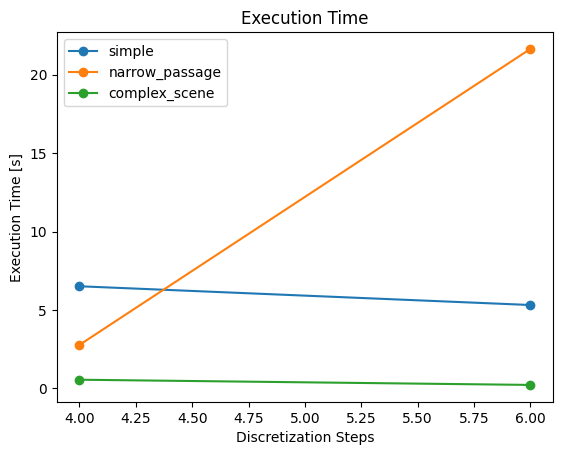

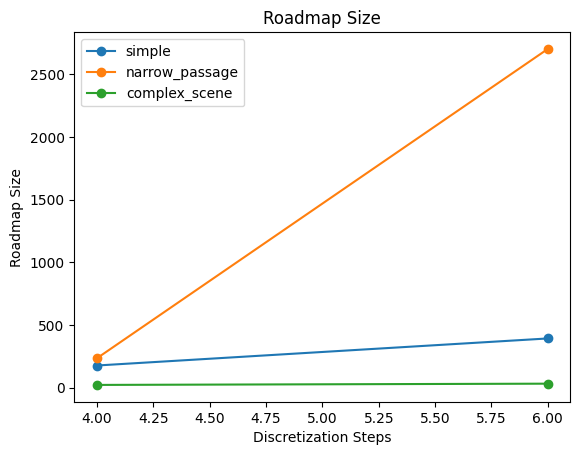

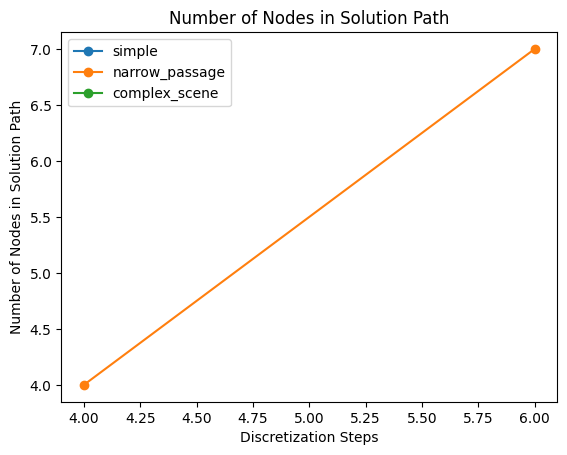

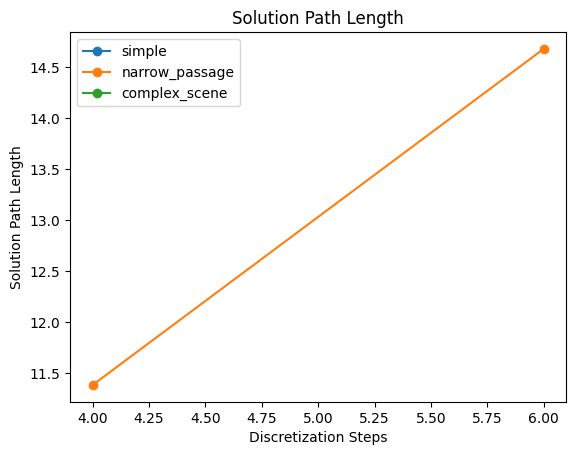

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np

disc_values = [4, 6]

configs = []
for disc in disc_values:
    disc_config = dict()
    disc_config["dof"] = 9
    disc_config["lowLimits"] = [-2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["highLimits"] = [2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["discretization"] = [disc for _ in range(disc_config["dof"])]
    disc_config["w"] = .5
    disc_config["heuristic"]  = "euclidean"
    disc_config["reopen"] = True
    disc_config["check_connection"] = True
    disc_config["lazy_check_connection"] = True
    disc_config["benchmarks"] = [0, 1, 2]

    configs.append(disc_config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")